# Project 3: Image recognizion. (Melanoma)
## Group 7: Emma, Laurits, Malthe, Mads og Jonas


## Loading the Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import fyp2021p3_group00_functions as util
import pandas as pd
from skimage import morphology
from skimage import filters
from skimage.morphology import opening

## Functions

## Loading the data

In [3]:
# First we make the path to the data
PATH = {}
PATH["data"] ="../data"

#print(PATH)
#Then we load the path for all the diffirent pictures as keys to their names.
PICTURES = {}
for path, subdirs, files in os.walk(PATH["data"]):
    for picture in files:
        PICTURES[picture[0:12]] = os.path.normpath(os.path.join(path, picture))

# Deleting 2 files from the dictionary to only include images (ie. png and jpg files)
del PICTURES['example_grou']
PICTURES.pop(".DS_Store")
images = pd.read_csv("../data/example_ground_truth.csv")
image_way = pd.DataFrame.from_dict(PICTURES, orient='index')
image_merge = images.merge(image_way, left_on ='image_id' , right_index=True)
#print(len(PICTURES))

# Exercise 1

– Use matplotlib.pyplot package to load an image and the corresponding segmentation. Display the images side by side (as subplots)


– Inspect the dimensions and values inside the images, what do you notice?


– How can you use the mask to measure the width or height of the skin lesion
at different points in the image? Can you now find the maximum width and
height? What about finding the maximum possible diameter of the lesion?


– Use the segmentation to mask out / erase the outside of the skin lesion. Can
you do this without a for loop?


– Try to extract the color of a single pixel inside the lesion, and store this
color. Can you now fill the entire lesion, just with this color?

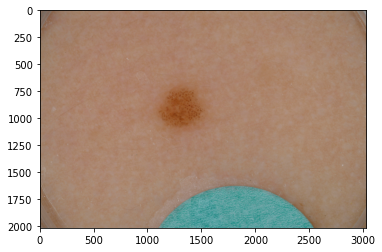

In [ ]:
# Loading an image

im = plt.imread('/work/fyp2021p03g07/data/example_image/ISIC_0004337.jpg')
plt.imshow(im);

In [ ]:
# Inspecting the dimensions

print(im.shape)
print(im.dtype)

(2016, 3024, 3)
uint8


NameError: name 'im' is not defined

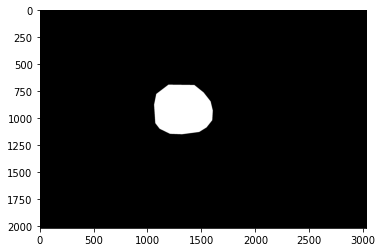

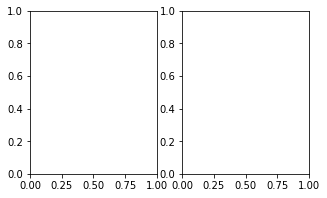

In [ ]:
# Displaying segmentation.png

mask = plt.imread('/work/fyp2021p03g07/data/example_segmentation/ISIC_0004337_segmentation.png')
plt.imshow(mask, cmap='gray');

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(im)
axes[1].imshow(mask, cmap='gray')
fig.tight_layout()


# Measuring width and height of the lesion with a mask
area, perimeter = util.measure_area_perimeter(mask)
print(area, perimeter)

# Finding min and max height of the lesion


# Finding max possible diameter of the lesion

2016


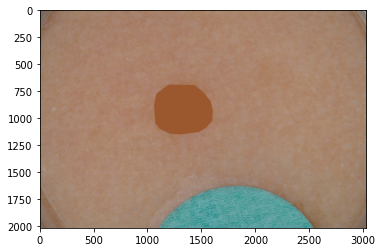

In [ ]:
#  Try to extract the color of a single pixel inside the lesion, and store this 
#  color. Can you now fill the entire lesion, just with this color?
Lesion_color = [im[800,1300,0],im[800,1300,1],im[800,1300,2]]
temp = np.array(im)
y = np.expand_dims(mask, axis=2)
print(im.shape[0])
for x_axis in range(im.shape[0]):
    for y_axis in range(mask.shape[1]):
       if mask[x_axis][y_axis] == 1:
            temp[x_axis,y_axis,0] = Lesion_color[0]
            temp[x_axis,y_axis,1] = Lesion_color[1]
            temp[x_axis,y_axis,2] = Lesion_color[2]

plt.imshow(temp);

#Lession_map = np.where(mask == 0, im, Lesion_color)

# Task 0: Explore the Data

Go through the data (csv file, images, segmentations) that you have available
to understand what’s available to you, and write a brief description. Decide if
this data is sufficient, or if cleaning is needed. For example, what do you do with
the images that are malignant (cancer), but not of the class you want to focus
on? Are there images of low quality? Etc. You are allowed to search for and add
other public dataset, to this set of images.

Description of Data: 
- 150 images of skin lesions
- Superpixel
- Segmentations of the images
- Features of the images, including ID, area and perimeter





In [4]:
# Cleaning the data to not include photos of keratosis

image_info = pd.read_csv("../data/example_ground_truth.csv")
cancer_free = image_info[(image_info['melanoma']== 0) & (image_info['seborrheic_keratosis']==0)]
melanoma = image_info[image_info['melanoma'] == 1]
keratosis = image_info[image_info['seborrheic_keratosis']==1]

#image_info
print("image_info: {0}, cancer_free: {1}, melanoma: {2}, keratosis: {3}"
.format(image_info.shape, cancer_free.shape, melanoma.shape, keratosis.shape))

image_info: (150, 3), cancer_free: (78, 3), melanoma: (30, 3), keratosis: (42, 3)


In [5]:
""" First we check for duplicates"""

#Checks for duplicated image IDs from image_info
image_id = set()
not_unique_id = 0
for i in image_info['image_id']:
    if i not in image_id:
        image_id.add(i)
    else:
        not_unique += 1
print('Number of duplicates image id: {0}'.format(not_unique_id))

#Checks that there is no duplicates in the pictures
image_unique = set()
not_unique_image = 0
for i in PICTURES:
    if i not in image_unique:
        image_unique.add(i)
    else:
        not_unique_image += 1
print('Number of duplicates images: {0}'.format(not_unique_image))

"""Then we checks that all ID's has a corresponding image, and vice versa"""

#Checks that all IDs in image info is in example folders
no_image = ()
for i in image_info['image_id']:
    if i not in PICTURES:
        no_image.add(i)
print('No image: {0}'.format(len(no_image)))


#Checks that all pictures in example image folder has a image ID in image_info
no_ID = ()
for i in PICTURES:
    x = i[0:12] #The first 12 characters is the ID
    if x not in image_id:
        not_in_truth_file.add(i)
print('No ID in image_info: {0}'.format(len(no_ID)))

Number of duplicates image id: 0
Number of duplicates images: 0
No image: 0
No ID in image_info: 0


In [6]:
# Function for checking for low quality pictures
not_fine = 0
fine = 0
High_Definition = 1920*1080

""" A Function that returns the number of pixels in an image that can
be used to check whether the image is low or high quality"""
def check_quality(image_id_jpg, minimum_resolution):
    im = plt.imread(PICTURES[image_id_jpg])
    resolution = im.shape
    num_of_pixels = resolution[0]*resolution[1]
    return num_of_pixels

for i in PICTURES:   
    x = check_quality(str(i), High_Definition)
    if x > High_Definition:
        fine += 1
    else: 
        not_fine += 1
        print(i)

print(not_fine)
print(fine)
#for images, path in PICTURES.items():
 #   check_quality(images, High_Definition)


ISIC_0010459
ISIC_0009995
2
148


# Task 1: Implement Two Features
Choose one of the ABC (Asymetry, Border or Color) features and implement a function to measure it for one
image. While you are doing this, you might want to create “toy” images where
you already know the results, for example a circle should be less asymmetric
than an ellipse, etc.
Once you are satisfied with your implementations, run them on all your
images, and examine the feature distributions for each class, for example using
scatter plots. Do you see differences between the classes?

## Asymmetry

In [ ]:
# har ikke fået lavet det til en funktion endnu

import matplotlib.image as mpimg
import cv2

# Cropping the mask
mask = plt.imread('/work/fyp2021p03g07/data/example_segmentation/ISIC_0004337_segmentation.png')
mask_cropped = mask[650:1180,1000:1650]

# Flipping the mask vertically and horizontally
mask_ver = np.fliplr(mask_cropped)
mask_hor = np.flipud(mask_cropped)

# Displaying the output for vertical
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
axes[0].imshow(mask_cropped,cmap='gray')
axes[1].imshow(mask_ver,cmap='gray')
fig.tight_layout()

# Displaying the output for horizontal
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
axes[0].imshow(mask_cropped,cmap='gray')
axes[1].imshow(mask_hor,cmap='gray')
fig.tight_layout()

# Subtracting images to see non-overlapping parts

# vil gerne bruge 'difference = cv2.subtract(image1, image2)' her
# men kan ikke importe cv2



##############################################

def get_difference(image_path_1, image_path_2, cnt):
    image1 = cv2.imread(mask_cropped)
    image2 = cv2.imread(mask_ver)
    difference = cv2.subtract(image1, image2)
    Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 255,cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
    difference[mask != 255] = [0, 0, 255]
    image1[mask != 255] = [0, 0, 255]
    image2[mask != 255] = [0, 0, 255]
    cv2.imwrite('difference_img/diff_image_' + str(cnt) + '.png', image1)


ImportError: libGL.so.1: cannot open shared object file: No such file or directory

## Border

In [ ]:
from skimage.morphology import opening
def find_border(mask):
    """Returns a ratio between the surcumfrance and the area of a mask. 
    It returns 0 for a perfect circle, and increasingly higher returns for larger 
    surcomfrance compared with area."""
    # Using the fact that all values within the area of the mask is 1, 
    # the area is equal to the sum of the mask
    ones = np.sum(mask)
    # Applying a gausian border to find the surcumfrance
    border = filters.difference_of_gaussians(mask,1) 
    # Reducing the size of the border.
    border = np.where((border < -0.01) & (border > 0.01), 1, border)
    border = np.where(border < 0.01 , 0, border)

    surcumfrance = np.sum(border)

    #plt.imshow(border, cmap='gray')

    Compactness = surcumfrance**2/ones*12
    print(Compactness)

    #return Compactness

find_border(mask)
test_square = np.pad(np.ones((100,200)), pad_width = 5, constant_values=0)
test_big_square = np.pad(np.ones((1000,2000)), pad_width = 5, constant_values=0)
find_border(test_big_square)
find_border(test_square)

# Idea from https://stackoverflow.com/questions/10031580/how-to-write-simple-geometric-shapes-into-numpy-arrays
xx, yy = np.mgrid[:200, :200]

circle = (xx - 100) ** 2 + (yy - 100) ** 2
circle1 = np.where(circle < 1500, 1, circle)
circle1 = np.where(circle1 > 1, 0, circle1)
circle2 = np.where(circle < 1850, 1, circle)
circle2 = np.where(circle2 > 1, 0, circle2)
find_border(circle1)
find_border(circle2)






9.420704743500279
13.578840583752644
13.429969975631446
0.0
0.0


## Colour

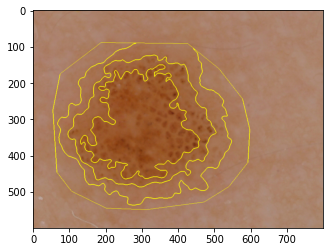

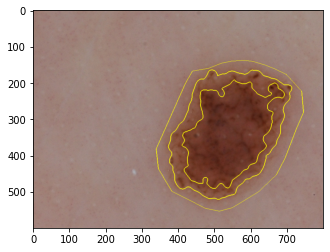

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

def color(image, mask):
    segments =  slic(image, n_segments= 4, compactness=0.1,sigma= 5, mask=mask)
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.imshow(mark_boundaries(image, segments))

    plt.show()

# Cancer free

mask = plt.imread('../data/example_segmentation/ISIC_0004337_segmentation.png')
mask = mask[600:1200, 1000:1800]

image = plt.imread('../data/example_image/ISIC_0004337.jpg')
image = image[600:1200, 1000:1800]

color(image, mask)
# ---------- # ----------
mask = plt.imread('../data/example_segmentation/ISIC_0013010_segmentation.png')
mask = mask[600:1200, 1000:1800]

image = plt.imread('../data/example_image/ISIC_0013010.jpg')
image = image[600:1200, 1000:1800]

color(image, mask)


# Cancer
mask = plt.imread('../data/example_segmentation/ISIC_0014809_segmentation.png')
mask = mask[1000:4500, 1500:5000]

image = plt.imread('../data/example_image/ISIC_0014809.jpg')
image = image[1000:4500, 1500:5000]

color(image, mask)





# Task 2: Predict the diagnosis
Split your data so that you are have training data and hold-out test data. Use
the training data to train different classifiers and investigate their parameters.
Once you made a choice, evaluate your classifier on the hold-out test data. Think
of different metrics you can use, and different ways to present your results.

# Task 3: open question
Use the data to formulate, motivate, answer, and discuss another research question of your choice. You may use other data or features here, that we did not
cover

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6c6ff636-1d68-49e2-b04b-ee0d9895f3db' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>